# Evaluation of Alaska Dataset

## Define filepaths 

In [1]:
root_dir = '../..'
data_dir = 'data'
rankings_dir = 'terms'
corpus_dir = 'corpus'
dataset_name = 'alaska'

## Load the ground truth

In [2]:
import os
import json

In [3]:
gt_filename = 'alaska_camera_gt.json'
gt_filepath = os.path.join(root_dir, data_dir, corpus_dir, gt_filename)

In [4]:
with open(gt_filepath, 'r') as fd:
    gt_dict = json.load(fd)

In [5]:
gt_dict

{'ENTITY#101': 'canon eos 5d mark iii',
 'ENTITY#102': 'canon eos 5d mark ii',
 'ENTITY#16': 'nikon d90',
 'ENTITY#18': 'canon eos 60d',
 'ENTITY#19': 'nikon d3300',
 'ENTITY#21': 'nikon d5100',
 'ENTITY#23': 'canon eos 7d',
 'ENTITY#36': 'nikon d3100',
 'ENTITY#37': 'nikon d80',
 'ENTITY#41': 'nikon d5200',
 'ENTITY#44': 'nikon d3200',
 'ENTITY#57': 'nikon d800',
 'ENTITY#58': 'nikon 1 j1',
 'ENTITY#6': 'nikon d5300',
 'ENTITY#7': 'olympus omd em5',
 'ENTITY#75': 'nikon d7000',
 'ENTITY#76': 'nikon d610',
 'ENTITY#8': 'nikon 1 j3',
 'ENTITY#84': 'nikon d300',
 'ENTITY#96': 'canon eos 70d'}

## Load rankings

In [6]:
import string
import pandas as pd
from collections import defaultdict

In [7]:
def tokenize(s):
    tokens = []
    for candidate in s.split():
        for c in candidate.split('_'):
            k = "".join([x for x in c if c not in string.punctuation]).lower()
            tokens.append(k)
    return tokens

In [8]:
test_names = ['', # default params
              '_sampling_terms_test1', 
              '_sampling_terms_test2', 
              '_sampling_records_test1', 
              '_sampling_records_test2', 
              '_sampling_records_and_terms_test1']

model_names = ['nn', 'bert']

In [9]:
k = 6
retrieved_data = defaultdict(list)

In [10]:
for model_name in model_names: 
    
    for test_name in test_names:
        test_dict = {}
        
        ranking_filename = f'ranking_{dataset_name}_{model_name}{test_name}.xlsx'
        ranking_filepath = os.path.join(root_dir, data_dir, rankings_dir, ranking_filename)
        
        df = pd.read_excel(ranking_filepath, index_col=0)
        df['term'] = df['term'].map(lambda x: x.replace('-',''))
        df['term'] = df['term'].map(lambda x: tokenize(x))
        
        grouped_df = df.groupby('label')
        
        for group_name, group_df in grouped_df:
            terms = group_df['term'].values[:k].tolist()
            test_dict[group_name] = terms
        
        retrieved_data[model_name].append(test_dict)

## Tokenize targets

In [11]:
import string

In [12]:
targets = {}
for entity_id, entity_name in gt_dict.items():
    targets[entity_id] = tokenize(entity_name)

## Precision and recall at k functions

In [13]:
import numpy as np

In [14]:
def stats_at_k(y_true, y_pred):
    yt = set(y_true)
    precision, recall = [], []
    buffer = set()
    for data in y_pred:
        buffer = buffer.union(set(data))
        tp = len(yt.intersection(buffer))
        fp = len(buffer.difference(yt))
        fn = len(yt.difference(buffer))
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    return precision, recall

In [15]:
def mean_stats(data, 
               model_name, 
               benchmark_names):

    outp, outr = {}, {}
    
    for i, tool in enumerate(benchmark_names):
        P, R = [], []
        
        for entity, y_true in targets.items():
            y_pred = data[model_name][i][entity]
            p, r = stats_at_k(y_true, y_pred)
            P.append(p)
            R.append(r)
        
        outp[tool] = np.array(P).mean(axis=0)
        outr[tool] = np.array(R).mean(axis=0)
    
    return outp, outr

## Visualize

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_precision_and_recall(outp, outr, model_name, benchmark_names):
    fig, ax = plt.subplots(figsize=(16, 8), ncols=2)
    
    for tool in benchmark_names:
        ax[0].plot(outp[tool], label=tool)
        ax[1].plot(outr[tool], label=tool)
    
    ax[0].set_title('Mean precision at k')
    ax[1].set_title('Mean recall at k')
    ax[0].set_xlabel('Number of terms')
    ax[1].set_xlabel('Number of terms')
    ax[0].set_ylabel('Precision')
    ax[1].set_ylabel('Recall')
    ax[0].set_xticklabels(range(0,7))
    ax[1].set_xticklabels(range(0,7))

    ax[0].legend()
    ax[1].legend()
    #plt.tight_layout()
    plt.savefig(f'prec_rec_atk_test_{model_name}.pdf')
    fig.suptitle(model_name, fontsize=20)
    plt.show()

In [19]:
benchmarks = ['default', 
              'sample_terms1', 
              'sample_terms2', 
              'sample_records1', 
              'sample_records2', 
              'sample_records_and_terms1']

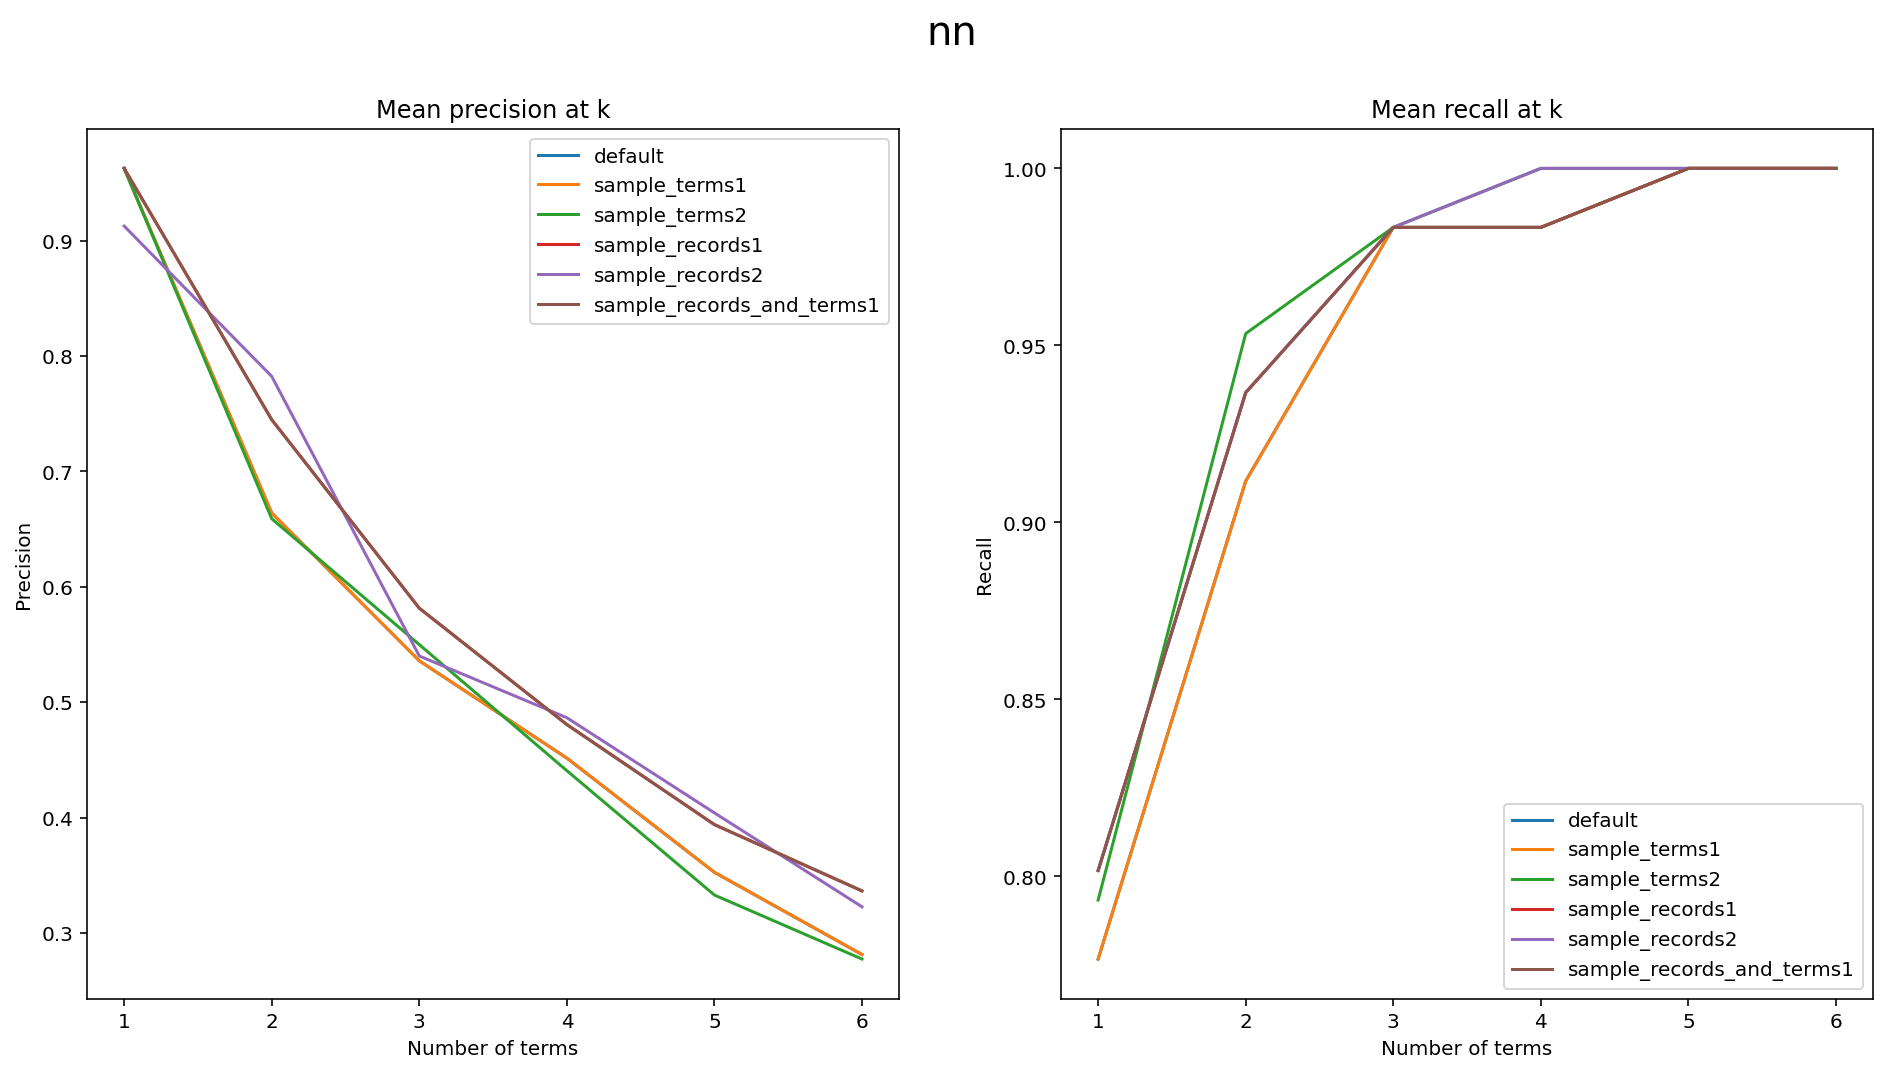

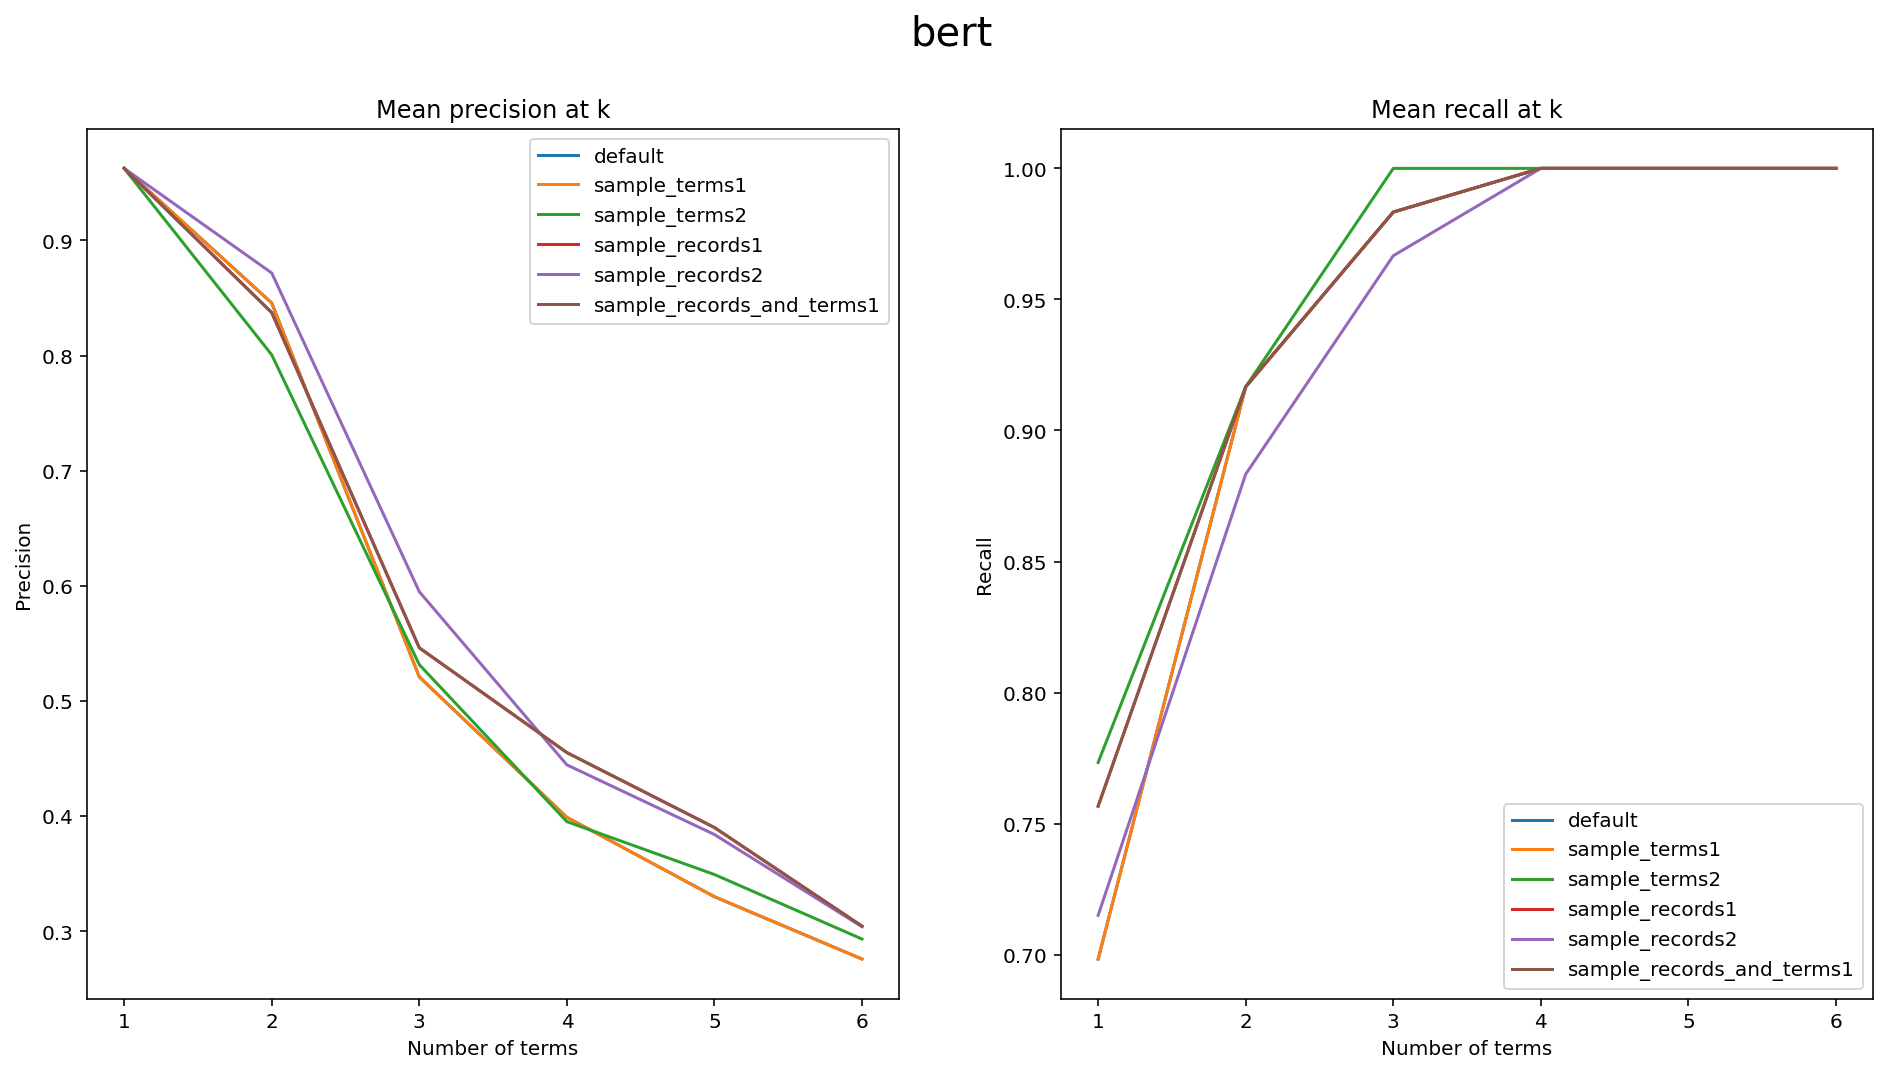

In [20]:
for model_name in model_names:
    outp, outr = mean_stats(retrieved_data, model_name, benchmarks)
    plot_precision_and_recall(outp, outr, model_name, benchmarks)

---